In [200]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

## DataFrame

In [139]:
df = pd.read_excel("C:\\Users\\ASUS-X515EP\\Documents\\LTV_Data.xlsx",
                  parse_dates=['Purchase Date'])

In [140]:
df = df.rename(columns={
    "Cookie ID":"user_id",
    "Session ID":'session_id',
    "Email":'email',
    "Purchase Date":'date',
    "Origin Channel":'channel',
    "Landing Page Type":'land_page',
    "Purchase Value":'value'
})

# перший день активності
df['min_day'] = df.groupby('user_id')['date'].transform('min')

In [141]:
# спосіб залучення та приземлення
df['got'] = df['channel'].astype('str') + "_" + df['land_page'].astype('str')

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     2627 non-null   int64         
 1   session_id  2627 non-null   int64         
 2   email       2627 non-null   object        
 3   date        2627 non-null   datetime64[ns]
 4   channel     2627 non-null   object        
 5   land_page   2627 non-null   object        
 6   value       2627 non-null   int64         
 7   min_day     2627 non-null   datetime64[ns]
 8   got         2627 non-null   object        
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 184.8+ KB


In [143]:
# змінюю тип даних
df['channel'] = df['channel'].astype('category')
df['land_page'] = df['land_page'].astype('category')
df['got'] = df['got'].astype('category')
df['value'] = df['value'].astype('int16')

In [144]:
# знаходжу тиждень першої активності
def week(date):
    start_of_week = date - pd.offsets.Week(weekday=6)
    if (date - start_of_week).days < 7:
        return start_of_week
    else:
        return date

df['week_reg'] = df['min_day'].apply(week)
del df['min_day']
df['date'] = df['date'].apply(week)
df.sample(5)

,user_id,session_id,email,date,channel,land_page,value,got,week_reg
1242,30406125,944893074,78717@university.edu,2022-08-28,Email,Category Page,15,Email_Category Page,2022-08-28
2623,79424107,571153589,61776@university.edu,2022-07-24,Email,Homepage,205,Email_Homepage,2022-07-10
525,11433088,296651540,29174@gmail.com,2022-08-07,Paid Social,Homepage,205,Paid Social_Homepage,2022-08-07
863,87706314,405928251,27141@gmail.com,2022-11-27,Email,Category Page,104,Email_Category Page,2022-11-27
2466,52329575,599251372,57480@gmail.com,2022-07-24,Email,Category Page,20,Email_Category Page,2022-07-24


In [145]:
# скільки тижнів минуло з дня перої активності
df['week_index'] = (df['date'] - df['week_reg']).dt.days // 7 + 1
df.sample(5)

,user_id,session_id,email,date,channel,land_page,value,got,week_reg,week_index
2090,33805522,155019971,32177@gmail.com,2022-08-07,Email,Homepage,38,Email_Homepage,2022-08-07,1
151,33006844,472578072,95431@gmail.com,2022-07-03,Paid Search,Homepage,68,Paid Search_Homepage,2022-07-03,1
490,84836688,856059774,69287@gmail.com,2022-11-06,Paid Social,Homepage,90,Paid Social_Homepage,2022-11-06,1
447,78795652,827253392,30899@gmail.com,2022-10-30,Paid Search,Homepage,85,Paid Search_Homepage,2022-10-30,1
1739,78103476,984682184,11886@gmail.com,2022-09-25,Email,Homepage,92,Email_Homepage,2022-09-25,1


In [148]:
# канал, який привів клієнта до нас
df_got = df[df['date']==df['week_reg']][['user_id', 'got']].rename(columns={"got":'contact_channel'})
df = df.merge(df_got,
              on='user_id',
              how='left')
df.sample(5)

,user_id,session_id,email,date,channel,land_page,value,got,week_reg,week_index,contact_channel
970,60094501,354565564,95945@gmail.com,2022-10-23,Email,Homepage,76,Email_Homepage,2022-10-23,1,Email_Homepage
1342,37954675,179217947,33780@gmail.com,2022-10-23,Email,Homepage,26,Email_Homepage,2022-10-23,1,Email_Homepage
431,76094418,485496941,97850@gmail.com,2022-09-04,Paid Search,Homepage,20,Paid Search_Homepage,2022-09-04,1,Paid Search_Homepage
2287,36179343,299104747,18660@gmail.com,2022-11-27,Paid Search,Category Page,83,Paid Search_Category Page,2022-07-31,18,Email_Homepage
1048,11322460,588141960,33446@university.edu,2022-11-06,Email,Homepage,76,Email_Homepage,2022-11-06,1,Email_Homepage


In [106]:
df.to_csv('C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\df_w.csv')

## Загальні тижневі когорти

In [107]:
# Щотижневі когорти
df_w = df.groupby(['week_index', 'week_reg'], as_index=False, observed=True).agg(
                                                                                nusers=('user_id', 'nunique'),
                                                                                value=('value', 'sum'),
                                                                                transaction=('user_id', 'count')
                                                                                )
df_w[['cs_$','cs_t']] = (df_w.sort_values(['week_reg', 'week_index'])
                        .groupby('week_reg')[['value', 'transaction']].cumsum())

# загальна кількість юзерів в когорті
df_w1 = df_w.copy()
df_w1 = df_w1.groupby('week_reg').nusers.max().reset_index().rename(columns={'nusers':'users'})

df_w = df_w.merge(df_w1, 
                 how='left',
                 on='week_reg')

df_w['arpu'] = df_w['cs_$'] / df_w['users']
df_w['avg_t'] = df_w['cs_t'] / df_w['users']
df_w['ltv'] = df_w['avg_t'] * df_w['arpu']
df_w.sample(5)

,week_index,week_reg,nusers,value,transaction,cs_$,cs_t,users,arpu,avg_t,ltv
241,14,2022-08-14,3,399,3,10427,134,84,124.130952,1.595238,198.018424
93,5,2022-08-14,4,291,4,7260,97,84,86.428571,1.154762,99.804422
181,10,2022-08-07,3,407,4,8525,101,65,131.153846,1.553846,203.792899
266,16,2022-08-21,4,374,4,9551,127,70,136.442857,1.814286,247.546327
74,4,2022-08-21,2,101,2,6165,83,70,88.071429,1.185714,104.427551


In [110]:
cohort_w = df_w.pivot(
    index='week_reg',
    columns='week_index',
    values='transaction'
)

# cohort_w.index = cohort_w.index.strftime('%Y-%m-%d')
cohort_w.head()

week_index,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
week_reg,,,,,,,,,,,,,,,,,,,,,
2022-06-26,31.0,NaN,NaN,1.0,1.0,2.0,2.0,3.0,3.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,NaN,3.0
2022-07-03,81.0,4.0,8.0,7.0,3.0,3.0,6.0,4.0,5.0,11.0,...,5.0,4.0,6.0,4.0,4.0,12.0,5.0,9.0,3.0,NaN
2022-07-10,89.0,2.0,6.0,9.0,4.0,5.0,3.0,6.0,5.0,4.0,...,3.0,5.0,5.0,7.0,6.0,2.0,1.0,2.0,2.0,NaN
2022-07-17,79.0,3.0,2.0,6.0,3.0,4.0,7.0,2.0,5.0,4.0,...,5.0,1.0,2.0,9.0,7.0,6.0,8.0,NaN,NaN,NaN
2022-07-24,89.0,2.0,5.0,7.0,2.0,3.0,4.0,6.0,6.0,3.0,...,5.0,7.0,4.0,3.0,5.0,2.0,NaN,NaN,NaN,NaN


<Axes: xlabel='week_index', ylabel='week_reg'>

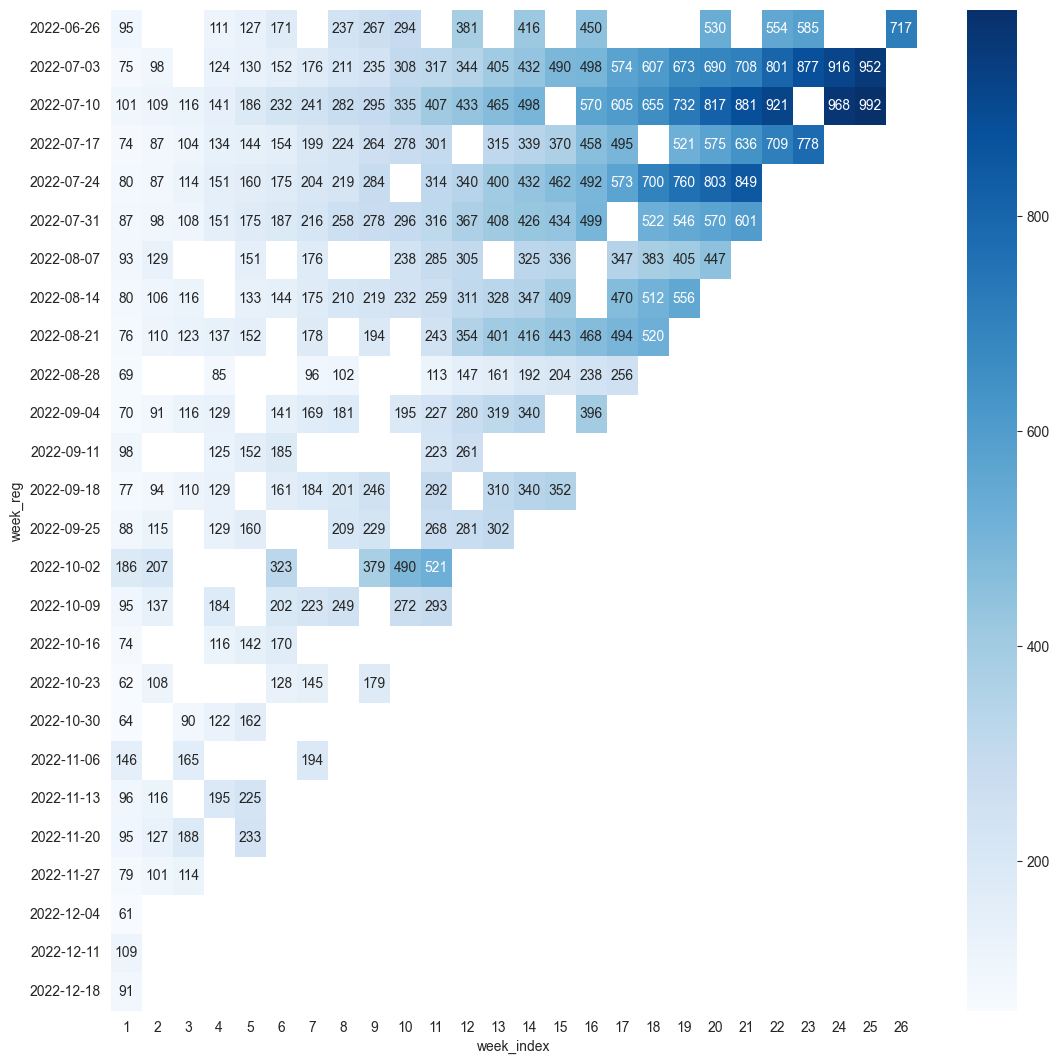

In [234]:
# Візуалізація щотижневих когорт
plt.figure(figsize=(13, 13))
sns.set_style("white")
sns.heatmap(cohort_w,
            annot=True,
            cmap='Blues',
            fmt='.0f')

In [109]:
df_w.to_csv('C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\df_ww.csv')

## Тижневі когорти на основі різних початкових каналів залучення

In [201]:
# Щотижневі когорти для різних каналів залучення
df_a = df.groupby(['contact_channel', 'week_index', 'week_reg'], as_index=False, observed=True).agg(
                                                                                nusers=('user_id', 'nunique'),
                                                                                value=('value', 'sum'),
                                                                                transaction=('user_id', 'count')
                                                                                )

df_a[['cs_$','cs_t']] = (df_a.sort_values(['week_reg', 'week_index', 'contact_channel'])
                        .groupby(['week_reg', 'contact_channel'])[['value', 'transaction']].cumsum())

# загальна кількість юзерів в когорті
df_a1 = df_a.copy()
df_a1 = df_a1.groupby(['week_reg', 'contact_channel']).nusers.max().reset_index().rename(columns={'nusers':'users'})

df_a = df_a.merge(df_a1, 
                 how='left',
                 on=['week_reg', 'contact_channel'])

df_a
df_a['arpu'] = df_a['cs_$'] / df_a['users']
df_a['avg_t'] = df_a['cs_t'] / df_a['users']
df_a['ltv'] = df_a['avg_t'] * df_a['arpu']
df_a.sample(5)

,contact_channel,week_index,week_reg,nusers,value,transaction,cs_$,cs_t,users,arpu,avg_t,ltv
181,Email_Homepage,1,2022-08-21,15,1136,15,1136,15,15.0,75.733333,1.000000,75.733333
381,Email_Homepage,16,2022-07-03,1,15,1,5263,69,27.0,194.925926,2.555556,498.144033
174,Email_Homepage,1,2022-07-03,27,2034,27,2034,27,27.0,75.333333,1.000000,75.333333
205,Email_Homepage,2,2022-08-14,3,221,3,1737,22,19.0,91.421053,1.157895,105.855956
166,Email_Category Page,22,2022-06-26,1,20,1,923,11,6.0,153.833333,1.833333,282.027778


In [228]:
cohort_a = df_a[(df_a['contact_channel']=='Email_Category Page')].pivot(
    index='week_reg',
    columns='week_index',
    values='ltv')

cohort_w.index = cohort_w.index.strftime('%Y-%m-%d')
cohort_a.head()

week_index,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
week_reg,,,,,,,,,,,,,,,,,,,,,
2022-06-26,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.555556,NaN,...,NaN,NaN,202.750000,NaN,250.833333,NaN,NaN,282.027778,NaN,401.194444
2022-07-03,91.687500,NaN,141.281250,175.687500,195.609375,NaN,NaN,NaN,213.937500,240.000000,...,NaN,427.500000,NaN,479.062500,533.500000,NaN,NaN,NaN,NaN,780.406250
2022-07-10,69.500000,78.111111,103.956790,153.500000,NaN,168.432099,200.833333,218.530864,280.108025,296.666667,...,488.858025,557.407407,NaN,599.765432,622.422840,NaN,NaN,NaN,648.500000,NaN
2022-07-17,68.181818,82.314050,NaN,94.760331,110.842975,NaN,129.917355,NaN,162.272727,206.016529,...,272.181818,333.024793,424.595041,446.727273,NaN,544.710744,696.0,802.396694,896.561983,NaN
2022-07-24,68.090909,NaN,95.297521,111.305785,NaN,NaN,NaN,NaN,129.049587,167.471074,...,NaN,304.892562,NaN,NaN,NaN,338.776860,375.0,408.049587,NaN,NaN


In [230]:
df_a.to_csv('C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\df_a.csv')